In [1]:
import torch
from torch.utils.data import Dataset
from astropy.io import fits
import astropy.units as u
from astropy.time import Time

import numpy as np
from arccnet.visualisation import utils as ut_v
from scipy.ndimage import rotate
import sunpy.map
import pandas as pd
import os
from arccnet.models import labels

import torchvision
import torchvision.ops as ops
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from p_tqdm import p_map

img_size_dic = {'MDI': 1024, 'HMI': 4096}

In [2]:
data_folder = os.getenv('ARCAFF_DATA_FOLDER', '../../../data/')
dataset_folder = 'arccnet-fulldisk-dataset-v20240917'
df_name = 'fulldisk-detection-catalog-v20240917.parq'

local_path_root = os.path.join(data_folder, dataset_folder)

df = pd.read_parquet(os.path.join(data_folder, dataset_folder, df_name))
df['time'] = df['datetime.jd1'] + df['datetime.jd2']
times = Time(df['time'], format='jd')
df['datetime'] = pd.to_datetime(times.iso)

selected_df  = df[df['filtered'] == False]

lon_trshld = 70
front_df = selected_df[(selected_df['longitude'] < lon_trshld) & (selected_df['longitude'] > -lon_trshld)]

min_size = 0.024
img_size_dic = {
    'MDI': 1024,
    'HMI': 4096}

cleaned_df = front_df.copy()
for idx, row in cleaned_df.iterrows():
    x_min, y_min = row['bottom_left_cutout']
    x_max, y_max = row['top_right_cutout']

    img_sz = img_size_dic.get(row['instrument'])
    width = (x_max - x_min) / img_sz
    height = (y_max - y_min) / img_sz
    
    cleaned_df.at[idx, 'width'] = width
    cleaned_df.at[idx, 'height'] = height

cleaned_df = cleaned_df[(cleaned_df['width'] >= min_size) & (cleaned_df['height'] >= min_size)]

cleaned_df

,target_time.jd1,target_time.jd2,datetime.jd1,datetime.jd2,instrument,path,processed_path_image,target_time_arc.jd1,target_time_arc.jd2,datetime_arc.jd1,...,record_TARPNUM_arc,record_TARPNUM_arc.mask,record_HARPNUM_arc,record_HARPNUM_arc.mask,quicklook_path,quicklook_path.mask,time,datetime,width,height
30,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.108398,0.062500
31,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.082031,0.058594
32,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.068359,0.059570
33,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.110352,0.060547
34,2450264.0,0.5,2450265.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,0.5,2450265.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450265e+06,1996-06-30 00:01:30.000,0.051758,0.059570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,2459818.0,0.5,2459818.0,0.499111,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459818.0,0.5,2459818.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459818e+06,2022-08-26 23:58:43.200,0.146240,0.056396
27390,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.145508,0.057373
27391,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8546,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.186279,0.108398
27392,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8539,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.085937,0.064697


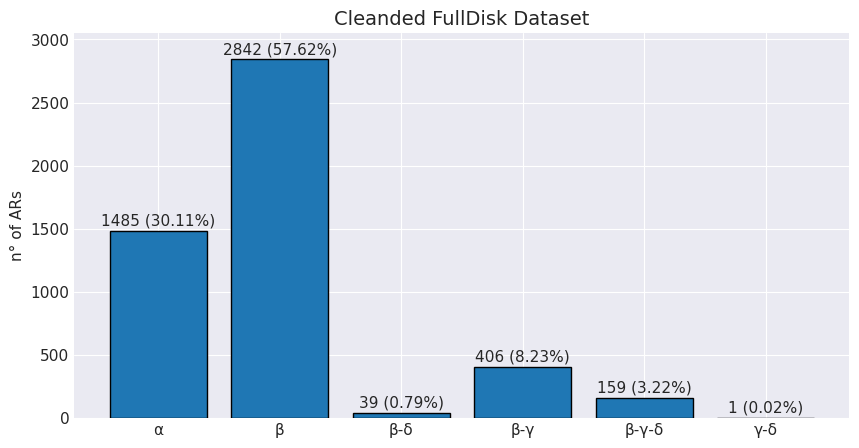

In [3]:
ut_v.make_classes_histogram(
    cleaned_df['magnetic_class'], 
    y_off=20, figsz=(10, 5), title='Cleanded FullDisk Dataset', ylim = 3050, bar_color='#1f77b4')

In [4]:
label_mapping = {
    "Alpha": "Alpha",
    "Beta": "Beta",
    "Beta-Delta": "Beta",
    "Beta-Gamma": "Beta-Gamma",
    "Beta-Gamma-Delta": "Beta-Gamma",
    "Gamma": "None",
    "Gamma-Delta": "None",
}

unique_labels = cleaned_df["magnetic_class"].map(label_mapping).unique()
label_to_index = {label: idx for idx, label in enumerate(unique_labels, start=1)}  # Start from 1

# Update DataFrame
cleaned_df["grouped_label"] = cleaned_df["magnetic_class"].map(label_mapping)
cleaned_df = cleaned_df[cleaned_df["grouped_label"] != "None"].copy()  # Exclude 'None' labels if necessary
cleaned_df["encoded_label"] = cleaned_df["grouped_label"].map(label_to_index)

In [5]:
split_idx = int(0.8 * len(cleaned_df))
train_df = cleaned_df[:500] #cleaned_df[:split_idx]
val_df = cleaned_df[-500:] #cleaned_df[split_idx:]

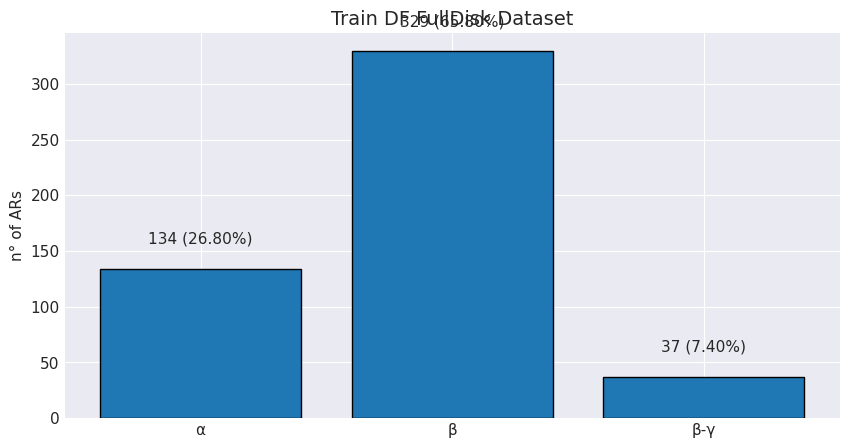

In [6]:
ut_v.make_classes_histogram(
    train_df['grouped_label'], 
    y_off=20, figsz=(10, 5), title='Train DF FullDisk Dataset', bar_color='#1f77b4')

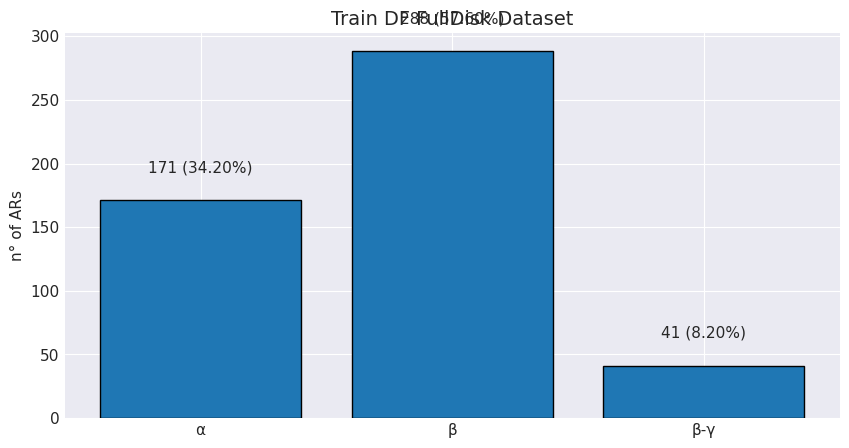

In [7]:
ut_v.make_classes_histogram(
    val_df['grouped_label'], 
    y_off=20, figsz=(10, 5), title='Validation DF FullDisk Dataset', bar_color='#1f77b4')

In [8]:
def preprocess_FD(row):
        arccnet_path_root = row["path"].split("/fits")[0]
        image_path = row["path"].replace(arccnet_path_root, local_path_root)
        # Load data with FITS and SunPy
        with fits.open(image_path) as img_fit:
            data = img_fit[1].data
            header = img_fit[1].header
            
        data = np.nan_to_num(data, nan=0.0)
        data = ut_v.hardtanh_transform_npy(data)        
        crota2 = header['CROTA2']
        data = rotate(data, crota2, reshape=False, mode='constant', cval=0)

        return data

In [9]:
class FulldiskDataset(Dataset):
    def __init__(self, df, local_path_root, transform=None):
        self.df = df
        self.local_path_root = local_path_root
        self.transform = transform
        self.img_size_dic = img_size_dic  # Add this to use img size dictionary

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        arccnet_path_root = row["path"].split("/fits")[0]
        image_path = row["path"].replace(arccnet_path_root, self.local_path_root)
        
        # Load data with FITS and SunPy
        with fits.open(image_path) as img_fit:
            data = img_fit[1].data
            header = img_fit[1].header
        
        # Transformations
        data = np.nan_to_num(data, nan=0.0)
        data = ut_v.hardtanh_transform_npy(data)        
        crota2 = header['CROTA2']
        data = rotate(data, crota2, reshape=False, mode='constant', cval=0)
        
        data = ut_v.pad_resize_normalize(data, target_height=1024, target_width=1024)

        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            data = self.transform(data)

        # Extract label
        label = row['encoded_label']

        # Compute bounding box
        img_sz = img_size_dic.get(row['instrument'])
        scale_factor = 1024 / img_sz
        x_min, y_min = row['bottom_left_cutout']
        x_max, y_max = row['top_right_cutout']
        bbox = [
            x_min * scale_factor,
            y_min * scale_factor,
            x_max * scale_factor,
            y_max * scale_factor,
        ]  # Absolute coordinates
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

        # Structure for Faster R-CNN
        target = {
            'boxes': torch.tensor([bbox], dtype=torch.float32),
            'labels': torch.tensor([label], dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': torch.tensor([area], dtype=torch.float32),
            'iscrowd': torch.zeros((1,), dtype=torch.int64),
        }

        return data, target

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# original_conv = model.backbone.body.conv1
# new_conv = torch.nn.Conv2d(
#     1, 
#     original_conv.out_channels, 
#     kernel_size=original_conv.kernel_size, 
#     stride=original_conv.stride, 
#     padding=original_conv.padding, 
#     bias=original_conv.bias is not None
# )
# with torch.no_grad():
#     new_conv.weight = torch.nn.Parameter(original_conv.weight.mean(dim=1, keepdim=True))
# model.backbone.body.conv1 = new_conv

num_classes = 1 + len(unique_labels)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
# Define Transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(mode='F'),  # Ensure single-channel ('F' mode for floating point)
    transforms.Resize((1024, 1024)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(mode='F'),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
])

In [12]:
# Hyperparameters
learning_rate = 0.005
num_epochs = 10

In [13]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# DataLoader
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

train_dataset = FulldiskDataset(train_df, local_path_root, transform=train_transforms)
val_dataset = FulldiskDataset(val_df, local_path_root, transform=train_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=32,
    collate_fn=collate_fn,
    pin_memory = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=32,
    collate_fn=collate_fn,
    pin_memory = True
)

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
scaler = torch.amp.GradScaler('cuda')

In [14]:
import torchvision.ops as ops
from tqdm import tqdm

# Function to compute IoU between predicted and true boxes
def compute_iou(boxes1, boxes2):
    """
    Compute IoU between two sets of boxes using torchvision's box_iou function.
    """
    return ops.box_iou(boxes1, boxes2)

# Training Loop
def train_one_epoch(epoch, model, train_loader, optimizer, device, scaler=None):
    model.train()
    total_loss = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast(device_type='cuda'):
                # During training, the model returns a loss dictionary
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")
    return avg_loss

# Validation Loop
def evaluate(model, val_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0
    num_validations = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation", unit="batch"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']

                true_boxes = target['boxes'].to(device)
                true_labels = target['labels'].to(device)

                # Calculate IoU between predicted and true boxes
                iou = compute_iou(pred_boxes, true_boxes)
                total_iou += iou.mean().item()  # Average IoU over the batch
                num_validations += 1

                # Save labels and predictions for further metrics like Precision/Recall
                all_labels.extend(true_labels.cpu().numpy())
                all_preds.extend(pred_labels.cpu().numpy())

    avg_iou = total_iou / num_validations
    print(f"Average IoU: {avg_iou:.4f}")

    # Here you could calculate additional metrics if necessary, e.g., Precision, Recall, or mAP

    return avg_iou


In [15]:
# Full training and validation loop
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, scaler=None):
    for epoch in range(num_epochs):
        # Training Phase
        avg_train_loss = train_one_epoch(epoch, model, train_loader, optimizer, device, scaler)

        # Validation Phase
        avg_iou = evaluate(model, val_loader, device)

        # Step the learning rate scheduler based on training loss or a validation metric
        scheduler.step(avg_train_loss)

        print(f"Epoch {epoch + 1} Summary: Train Loss = {avg_train_loss:.4f}, Validation IoU = {avg_iou:.4f}")

In [16]:
train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, scaler)

Epoch 1: 100%|██████████| 125/125 [00:42<00:00,  2.93batch/s]


Epoch 1, Training Loss: 0.2512


Validation: 100%|██████████| 125/125 [02:50<00:00,  1.36s/batch]
/home/edoardo/miniforge3/envs/ARCAFF/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average IoU: nan
Epoch 1 Summary: Train Loss = 0.2512, Validation IoU = nan


Epoch 2: 100%|██████████| 125/125 [00:42<00:00,  2.96batch/s]


Epoch 2, Training Loss: 0.1867


Validation:  34%|███▎      | 42/125 [01:19<02:36,  1.88s/batch]


KeyboardInterrupt: 

In [17]:
print(f"Predicted Boxes: {pred['boxes']}")

NameError: name 'pred' is not defined

In [18]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(